In [2]:
import matplotlib.pyplot as plt
import numpy as np

Equally spaced or random uniform initial positions

Velocities can be drawn from well defined values $\{−v_0, 0, +v_0\}$ or from a gaussian Maxwell velocity distributions.

Situation where the numbers of $A$ and $\overline A$ are exactly the same or not

In [3]:
n = 10 # nb of particles

L = 1 # box size
v0 = 1 # initial velocity

x = L*np.random.rand(n)
v = [-v0 if v <= 0.33 
     else 0 if v <= 0.67 
     else v0 
     for v in v0*np.random.rand(n)]

print(x)
print(v)

[0.07104184 0.89999923 0.22406153 0.36405328 0.16452574 0.86803995
 0.2132393  0.35415957 0.52523882 0.82787201]
[0, 0, 0, 1, -1, 0, 0, 0, -1, 1]


Compute positions $x_i(iδt)$ for a discrete sequence of time values $iδt$.
Particles are put back in the interval $[0, L]$ whenever they escape.

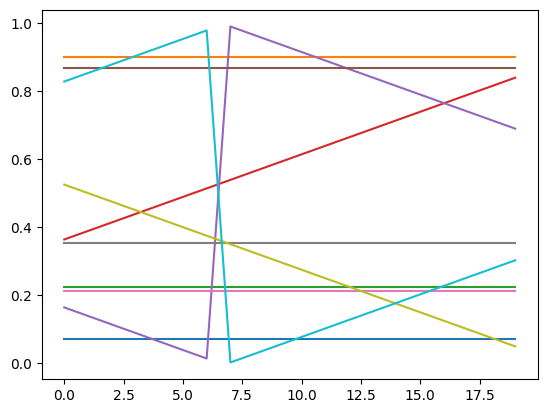

In [4]:
N = 20
dt = 1/40

x_t = np.zeros((N, n))

for t in range(N):
    x_t[t] = x
    for i in range(n):
        x[i] = x[i] + v[i]*dt

        if x[i] >= L: x[i] = x[i] - L
        elif x[i] < 0: x[i] = x[i] + L

for i in range(n):
    plt.plot(range(N), [e[i] for e in x_t])
plt.show()